In [1]:
import pyodbc
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
import sweetviz as sv

In [22]:
#pip install datatable

Note: you may need to restart the kernel to use updated packages.


In [3]:
import datatable as dt

### Import the data from SQL

In [4]:
### In windows, Using a ODBC DNS (predefined connection name)
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=DUSHI-DELL\SQLEXPRESS;"
                      "Database=Fraud Detection;"
                      "Trusted_Connection=yes;")

In [25]:
### Get the train table
df_fraud = pd.read_sql("SELECT * FROM Train",cnxn)

### Import data from csv directly

In [5]:
train_transaction  = dt.fread("C:/Users/Rita/Documents/DScourse/Final_Project_Fraud/Data/train_transaction.csv",sep=",")
test_transaction  =  dt.fread("C:/Users/Rita/Documents/DScourse/Final_Project_Fraud/Data/test_transaction.csv",sep=",")

train_identity = dt.fread("C:/Users/Rita/Documents/DScourse/Final_Project_Fraud/Data/train_identity.csv",sep=",")
test_identity = dt.fread("C:/Users/Rita/Documents/DScourse/Final_Project_Fraud/Data/test_identity.csv",sep=",")

In [26]:
df_fraud.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,None,NaN,None,None,None,None,None,None,None,None
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,None,NaN,None,None,None,None,None,None,None,None
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,None,NaN,None,None,None,None,None,None,None,None
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,None,NaN,None,None,None,None,None,None,None,None
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [27]:
df_fraud.shape

(590540, 434)

In [12]:
### Get the test tables
df_test_transaction = pd.read_sql("SELECT * FROM test_transaction",cnxn)

In [14]:
df_test_transaction.shape

(506691, 393)

In [16]:
### Get the test table
df_test_identity = pd.read_sql("SELECT * FROM test_identity",cnxn)

In [17]:
df_test_identity.shape

(141907, 41)

In [18]:
df_test = pd.merge(df_test_transaction,df_test_identity, on='TransactionID', how='left',left_index=True,right_index=True)

In [28]:
df_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,chrome 67.0,NaN,,,F,F,T,F,desktop,
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,,NaN,,,,,,,,
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,chrome 67.0,NaN,,,F,F,T,F,desktop,Windows
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,chrome 67.0,NaN,,,F,F,T,F,desktop,Windows
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,chrome 67.0,24.0,2880x1800,match_status:2,T,F,T,T,desktop,MacOS


#### Reduce memory

In [31]:
import gc
import os

del df_test_transaction, df_test_identity; x = gc.collect()

In [33]:
print('train data memory in MB:', df_fraud.memory_usage().sum() / 1024**2) 
print('test data memory in MB:', df_test.memory_usage().sum() / 1024**2) 

train data memory in MB: 1955.3709106445312
test data memory in MB: 1673.8679428100586


In [35]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                      props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64) 
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",props[col].dtype)
            #print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

In [36]:
reduce_mem_usage(df_test)
reduce_mem_usage(df_fraud)

Memory usage of properties dataframe is : 1673.8679428100586  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  459.05740547180176  MB
This is  27.42494755596697 % of the initial size
Memory usage of properties dataframe is : 1955.3709106445312  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  546.287467956543  MB
This is  27.937792517148328 % of the initial size


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,99,150,discover,142,...,None,255,None,None,None,None,None,None,None,None
1,2987001,0,86401,29.000000,W,2755,404,150,mastercard,102,...,None,255,None,None,None,None,None,None,None,None
2,2987002,0,86469,59.000000,W,4663,490,150,visa,166,...,None,255,None,None,None,None,None,None,None,None
3,2987003,0,86499,50.000000,W,18132,567,150,mastercard,117,...,None,255,None,None,None,None,None,None,None,None
4,2987004,0,86506,50.000000,H,4497,514,150,mastercard,102,...,samsung browser 6.2,32,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,99,150,visa,226,...,None,255,None,None,None,None,None,None,None,None
590536,3577536,0,15811049,39.500000,W,10444,225,150,mastercard,224,...,None,255,None,None,None,None,None,None,None,None
590537,3577537,0,15811079,30.950001,W,12037,595,150,mastercard,224,...,None,255,None,None,None,None,None,None,None,None
590538,3577538,0,15811088,117.000000,W,7826,481,150,mastercard,224,...,None,255,None,None,None,None,None,None,None,None


### EDA

In [37]:
advert_report = sv.analyze(df_fraud,target_feat='isFraud', pairwise_analysis='off')

In [38]:
advert_report.show_html('df_fraud.html')

Report df_fraud.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [24]:
from sklearn.metrics import log_loss, roc_auc_score
import datatable as dt
from datatable.models import Ftrl

In [6]:
df_fraud.shape

(590540, 434)

In [12]:
df_fraud.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 434, dtype: object

In [39]:
summary = pd.DataFrame(df_fraud.dtypes, columns=['dtypes'])
summary

,dtypes
TransactionID,uint32
isFraud,uint8
TransactionDT,uint32
TransactionAmt,float32
ProductCD,object
...,...
id_36,object
id_37,object
id_38,object
DeviceType,object


In [41]:
conda install -c conda-forge pandas-profiling


Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Rita\anaconda3

  added / updated specs:
    - pandas-profiling


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38haa244fe_0         3.1 MB  conda-forge
    confuse-1.4.0              |     pyhd3deb0d_0          21 KB  conda-forge
    htmlmin-0.1.12             |             py_1          21 KB  conda-forge
    imagehash-4.2.0            |     pyhd8ed1ab_0         292 KB  conda-forge
    missingno-0.4.2            |             py_1          12 KB  conda-forge
    pandas-profiling-2.9.0     |     pyh9f0ad1d_0         176 KB  conda-forge
    phik-0.10.0                |             py_0         578 KB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    s

In [42]:
from pandas_profiling import ProfileReport

In [43]:
profile = ProfileReport(df_fraud, title="Pandas Profiling Report")

In [44]:
profile.to_file("fraud_EDA.html")

PicklingError: Could not pickle the task to send it to the workers.

In [46]:
profile = ProfileReport(df_fraud, minimal=True)
profile.to_file("output.html")

### Target Distribution

In [47]:
df_fraud['TransactionAmt'] = df_fraud['TransactionAmt'].astype(float)
total = len(df_fraud)
total_amt = df_fraud.groupby(['isFraud'])['TransactionAmt'].sum().sum()

In [48]:
total_amt

79738948.6260432

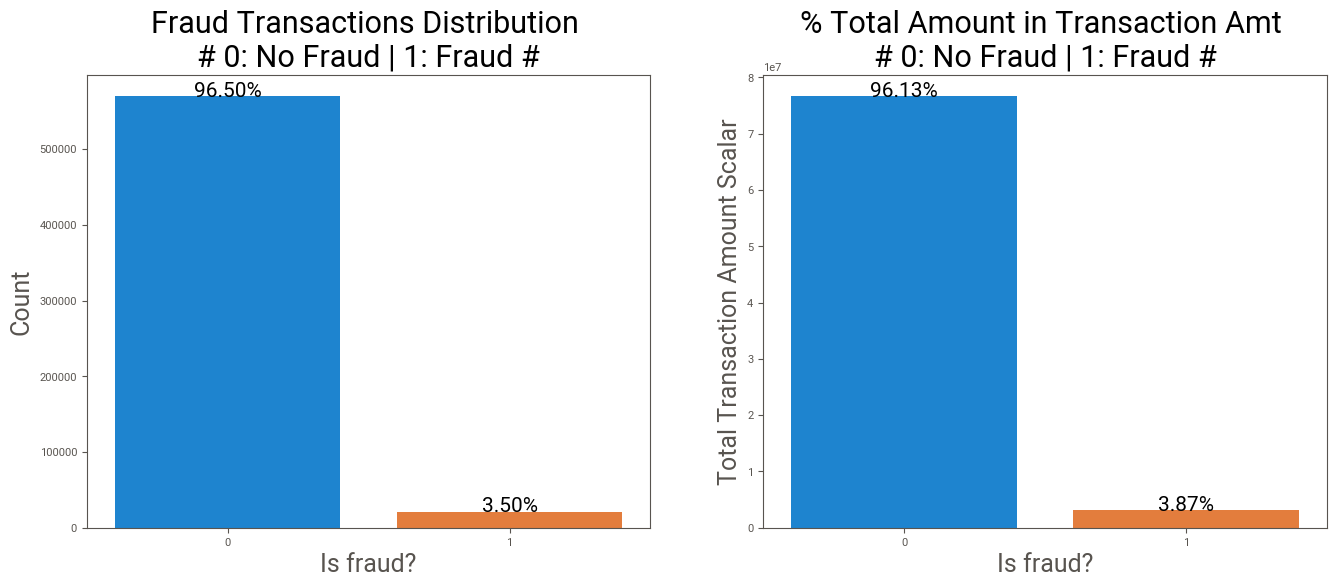

In [53]:
plt.figure(figsize = (16,6))
plt.subplot(121)
g = sns.countplot(x = 'isFraud', data= df_fraud)
g.set_title('Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #', fontsize = 22)
g.set_xlabel('Is fraud?', fontsize= 18)
g.set_ylabel('Count', fontsize = 18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
           height + 3,
          '{:1.2f}%'.format(height/total*100),
          ha = 'center', fontsize = 15)
    
perc_amt = (df_fraud.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 

### Product 

In [54]:
tmp = pd.crosstab(df_fraud['ProductCD'], df_fraud['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

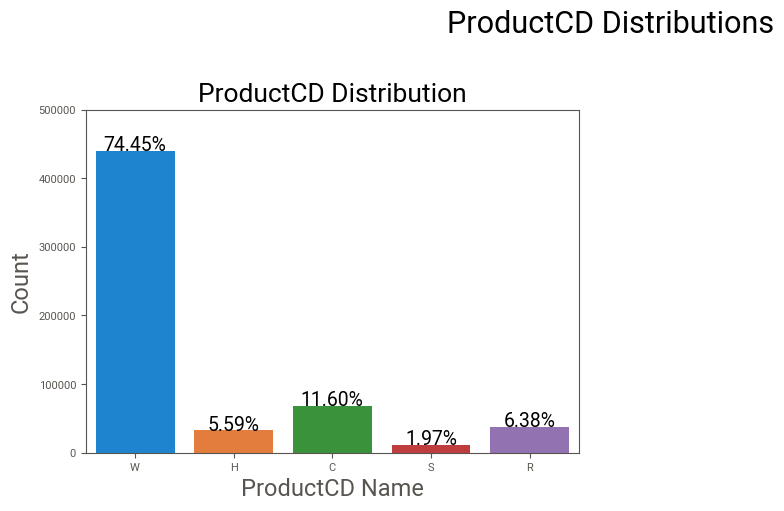

In [55]:
plt.figure(figsize = (14,10))
plt.suptitle('ProductCD Distributions', fontsize = 22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_fraud)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

Text(0, 0.5, 'Count')

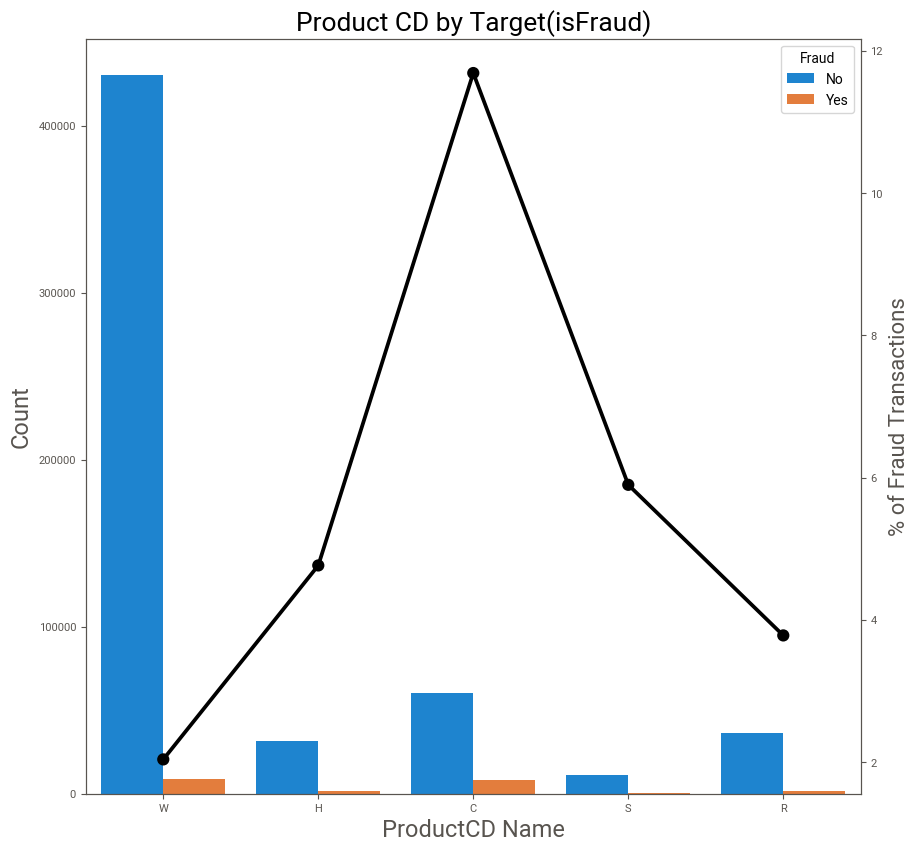

In [56]:
#plt.subplot(222)
plt.figure(figsize = (10,10))
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_fraud)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

In [ ]:
plt.figure(figsize = (5,5))
g3 = sns.boxenplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud',
                  data=df_trans[df_trans['TransactionAmt']<=2000])
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

W, C and R are the most frequent values,
We can note that in W, H and R the distribution of Fraud values are slightly higher than the Non-Fraud Transaction

### Id Columns

In [ ]:
num_id_cols = []
for col in train.columns:
    if train[col].dtype != 'O' and col[0:2] == 'id':
        num_id_cols.append(col)
        
print('Numerical ID colums: ', len(num_id_cols))
print(num_id_cols)
print('='*60)
print('id_yy columns with at least one null =', train[num_id_cols].isnull().any().sum())

cols = 4
rows = math.ceil(len(num_id_cols)/cols)
#print(rows, cols)

font = {'weight' : 'normal',
        'size' : 18}

matplotlib.rc('font', **font)

f, ax = plt.subplots(rows, cols, figsize = (40,40))
plt.rcParams.update({'font.size': 16})

for i, col in enumerate(num_id_cols):
    sns.distplot(a = train[col], ax = ax[int(i/cols)][i%cols], kde = False)
    #ax[int(i/cols)][i%cols].set_title('Distribution of ', col)
    #ax[int(i/cols)][i%cols].set_xlabel(size = 20)

ax[-1][-1].axis('off')
plt.show()